<a href="https://colab.research.google.com/github/Jade-Cartagena/QSAR-QSPR-Predictive-Models/blob/Predictive-Models/Partial_Least_Square.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RepeatedKFold
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.metrics import (
    precision_recall_curve, classification_report, confusion_matrix,
    f1_score, accuracy_score, roc_auc_score,
    r2_score, mean_squared_error, mean_absolute_error
)
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
from rdkit.DataStructs.cDataStructs import ConvertToNumpyArray

[05:49:13] WARNING: not removing hydrogen atom without neighbors



=== PLS Regression with Validation for 'Antioxidant' ===

✅ Best model for 'Antioxidant' → n_components = 18

📊 Final Evaluation on Test Set for 'Antioxidant'
Optimal Threshold: 0.414
ROC AUC: 0.894
Accuracy: 0.850
F1 Score: 0.831
R² Score: 0.541
RMSE: 0.339
MAE: 0.238
AAD: 0.238
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.93      0.87       421
           1       0.91      0.76      0.83       391

    accuracy                           0.85       812
   macro avg       0.86      0.85      0.85       812
weighted avg       0.86      0.85      0.85       812



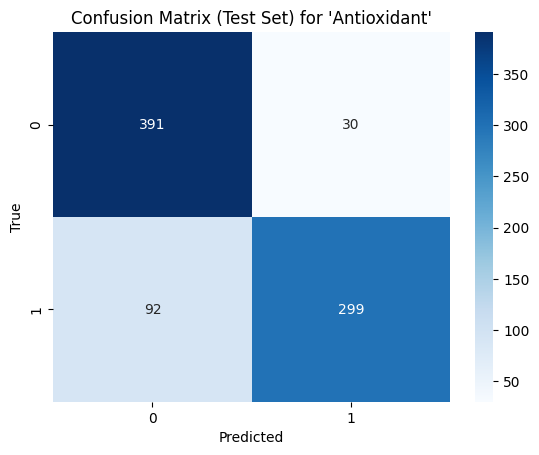

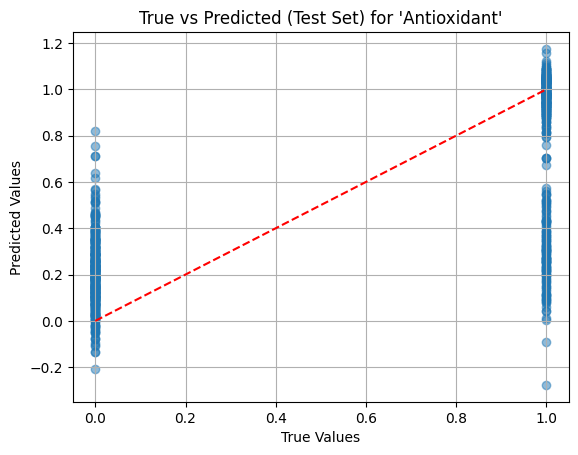


=== PLS Regression with Validation for 'Anti-inflammatory' ===

✅ Best model for 'Anti-inflammatory' → n_components = 96

📊 Final Evaluation on Test Set for 'Anti-inflammatory'
Optimal Threshold: 0.372
ROC AUC: 0.931
Accuracy: 0.862
F1 Score: 0.857
R² Score: 0.592
RMSE: 0.319
MAE: 0.219
AAD: 0.219
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.86      0.87       421
           1       0.85      0.86      0.86       391

    accuracy                           0.86       812
   macro avg       0.86      0.86      0.86       812
weighted avg       0.86      0.86      0.86       812



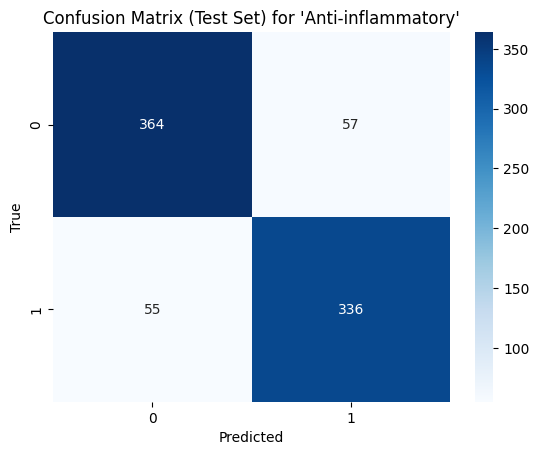

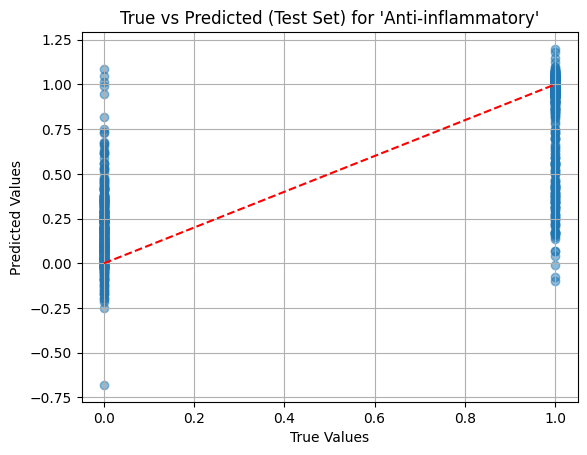


=== PLS Regression with Validation for 'Toxic' ===

✅ Best model for 'Toxic' → n_components = 81

📊 Final Evaluation on Test Set for 'Toxic'
Optimal Threshold: 0.554
ROC AUC: 0.931
Accuracy: 0.876
F1 Score: 0.877
R² Score: 0.589
RMSE: 0.321
MAE: 0.229
AAD: 0.229
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.84      0.87       416
           1       0.85      0.91      0.88       396

    accuracy                           0.88       812
   macro avg       0.88      0.88      0.88       812
weighted avg       0.88      0.88      0.88       812



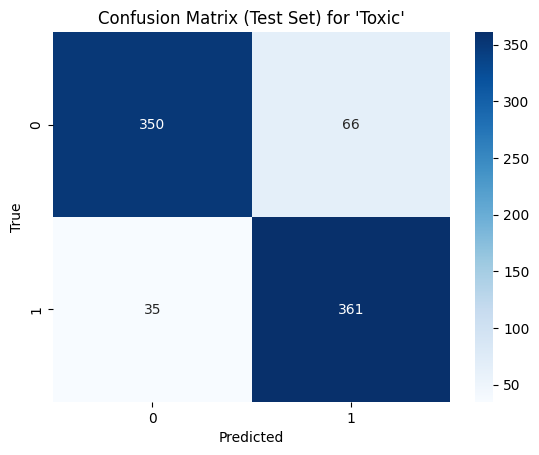

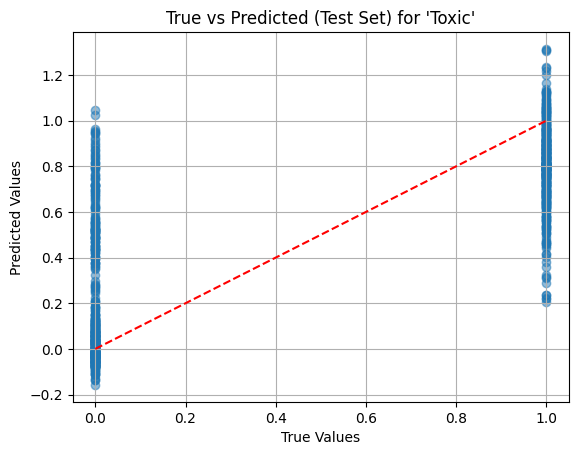

In [ ]:
# Load dataset
df = pd.read_csv("/content/QSAR-QSPR Finalized Dataset.csv")
smiles_list = df["SMILES"].tolist()

# Generate Morgan fingerprints
generator = GetMorganGenerator(radius=2, fpSize=2048)
fps = []
for smi in smiles_list:
    mol = Chem.MolFromSmiles(smi)
    if mol:
        fp = generator.GetFingerprint(mol)
        arr = np.zeros((2048,), dtype=int)
        ConvertToNumpyArray(fp, arr)
        fps.append(arr)
    else:
        fps.append(np.zeros((2048,), dtype=int))

fingerprint_df = pd.DataFrame(fps, columns=[f'FP_{i}' for i in range(2048)])

# Drop unused columns
df = df.drop(columns=["SMILES", "IUPAC_NAME", "NAME"])

# Target columns
target_cols = ['Antioxidant', 'Anti-inflammatory', 'Toxic']
df[target_cols] = df[target_cols].astype(int)

# Combine descriptor and fingerprint features
descriptor_features = df.drop(columns=target_cols).select_dtypes(include='number')
features = pd.concat([descriptor_features, fingerprint_df], axis=1)

# Split into 80% train+val and 20% test
X_temp, X_test, y_temp_all, y_test_all = train_test_split(
    features.values, df[target_cols], test_size=0.2, random_state=42
)

# RepeatedKFold configuration
rkf = RepeatedKFold(n_splits=4, n_repeats=1, random_state=42)

# Loop over each target
for target in target_cols:
    print(f"\n=== PLS Regression with Validation for '{target}' ===")
    y_temp = y_temp_all[target].values
    y_test = y_test_all[target].values

    fold = 1
    best_score = -np.inf
    best_n = None
    best_model = None

    # Cross-validation to select best model
    for train_idx, val_idx in rkf.split(X_temp):
        X_train, X_val = X_temp[train_idx], X_temp[val_idx]
        y_train, y_val = y_temp[train_idx], y_temp[val_idx]

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)

        selector = SelectKBest(score_func=mutual_info_regression, k=200)
        X_train_selected = selector.fit_transform(X_train_scaled, y_train)
        X_val_selected = selector.transform(X_val_scaled)

        param_dist = np.random.choice(np.arange(5, 101), size=3, replace=False)

        for n_comp in param_dist:
            model = PLSRegression(n_components=n_comp)
            model.fit(X_train_selected, y_train)
            y_pred_inner = model.predict(X_val_selected).ravel()
            score = -mean_squared_error(y_val, y_pred_inner)

            if score > best_score:
                best_score = score
                best_n = n_comp
                best_model = model
                best_scaler = scaler
                best_selector = selector

    print(f"\n✅ Best model for '{target}' → n_components = {best_n}")

    # === Final Test Set Evaluation ===
    final_scaler = StandardScaler()
    X_temp_scaled = final_scaler.fit_transform(X_temp)
    X_test_scaled = final_scaler.transform(X_test)

    final_selector = SelectKBest(score_func=mutual_info_regression, k=100)
    X_temp_selected = final_selector.fit_transform(X_temp_scaled, y_temp)
    X_test_selected = final_selector.transform(X_test_scaled)

    final_model = PLSRegression(n_components=best_n)
    final_model.fit(X_temp_selected, y_temp)

    # Test set prediction
    y_test_pred = final_model.predict(X_test_selected)
    y_temp_pred = final_model.predict(X_temp_selected)

    precisions, recalls, thresholds = precision_recall_curve(y_temp, y_temp_pred)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
    best_threshold = thresholds[np.argmax(f1_scores)]
    y_test_pred_class = (y_test_pred >= best_threshold).astype(int)

    acc = accuracy_score(y_test, y_test_pred_class)
    f1 = f1_score(y_test, y_test_pred_class)
    roc_auc = roc_auc_score(y_test, y_test_pred)
    r2 = r2_score(y_test, y_test_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    mae = mean_absolute_error(y_test, y_test_pred)
    aad = np.mean(np.abs(y_test - y_test_pred))

    print(f"\n📊 Final Evaluation on Test Set for '{target}'")
    print(f"Optimal Threshold: {best_threshold:.3f}")
    print(f"ROC AUC: {roc_auc:.3f}")
    print(f"Accuracy: {acc:.3f}")
    print(f"F1 Score: {f1:.3f}")
    print(f"R² Score: {r2:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print(f"MAE: {mae:.3f}")
    print(f"AAD: {aad:.3f}")
    print("Classification Report:\n", classification_report(y_test, y_test_pred_class))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_test_pred_class)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix (Test Set) for '{target}'")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # Scatter plot
    plt.scatter(y_test, y_test_pred, alpha=0.5)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title(f"True vs Predicted (Test Set) for '{target}'")
    plt.grid(True)
    plt.show()